# Simulation of ratial sampling

Import the required libraries and the image data

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
#import sigpy
import sigpy.mri
import sigpy.plot

sitk_t1=sitk.ReadImage('t1.nii.gz')
t1=sitk.GetArrayFromImage(sitk_t1)
print(t1.shape)

(90, 256, 256)


We use the middle slice.

When using `sigpy.plot.ImagePlot`, the rows are flipped, so we compensate for this when plotting the image

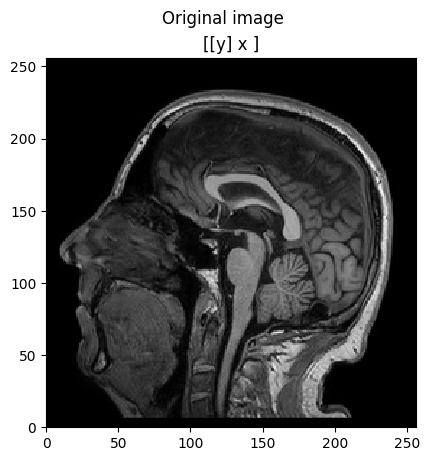

In [2]:
img_original = t1[45]
sigpy.plot.ImagePlot(sigpy.flip(img_original,axes=(2,)),title='Original image')



Generate the coordinates where the k-space will be sampled using `sigpi.mri.radial`. Contraty to what is shown in the project instructions, the spokes don't go across the origin, but rather, they expand from the origin, starting at the positive y-axis and turning clockwise for each consecutive spoke. Since the instructions give a spoke of 256 samples across the origin, we generate our spokes having 128 samples from the origin. To begin with, we acquire 180 spokes, equivalent to 90 of the spokes assumed in the project instructions.


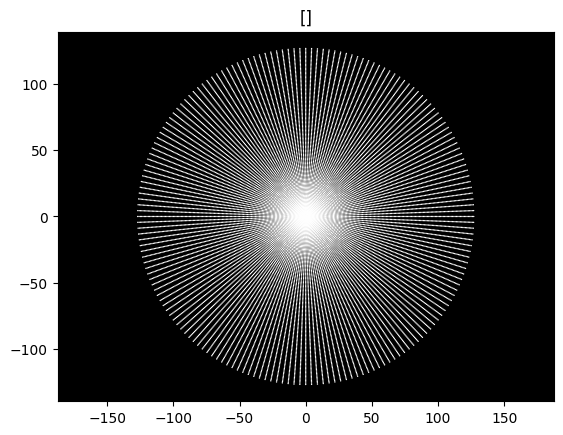

In [3]:
coord = sigpy.mri.radial([180,128,2],[256,256],golden=False)
sigpy.plot.ScatterPlot(coord)

Since the spokes are generated with the origin in the middle, but the image is an array whose pixel at (0,0) lies on the top left corner, we need to translate the spokes set to the center of the image. For this we have created a function to translate the spokes set to the middle pixel of any image:

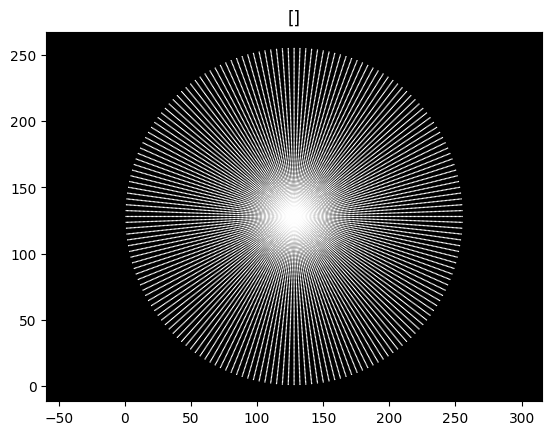

In [4]:
def translate_spokes_to_img_coord(spokes, im_size=(256,256)):
    x_shift = np.floor(im_size[1]/2) # x_shift determines how columns will be shifted
    y_shift = np.floor(im_size[0]/2) # y_shift determines how rows will be shifted
    new_spokes = []
    for spoke in spokes:
        new_spoke = []
        for point in spoke:
            new_point = [point[0] + x_shift, abs(point[1] - y_shift)]
            new_spoke.append(new_point)
        new_spokes.append(new_spoke)
    return np.array(new_spokes)

coord = translate_spokes_to_img_coord(coord)
sigpy.plot.ScatterPlot(coord)

Now we obtain the density compensation factor for the k-space

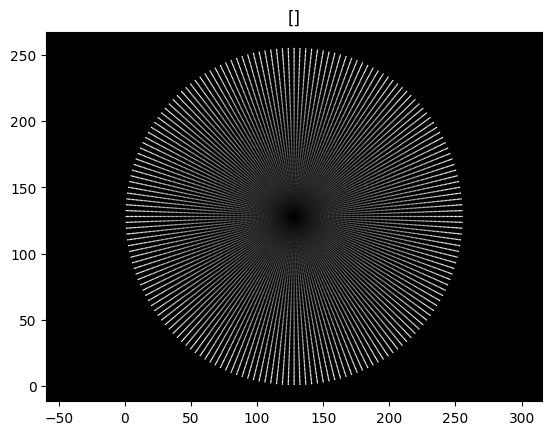

In [5]:
dcf = ((coord[...,0]-128)**2+(coord[...,1]-128)**2)**0.5
sigpy.plot.ScatterPlot(coord,dcf)

We obtain the fourier transform of the image (k-space) and sample it with the coordinates we acquired previously using the sigpy functions `fft` and `interpolate`.


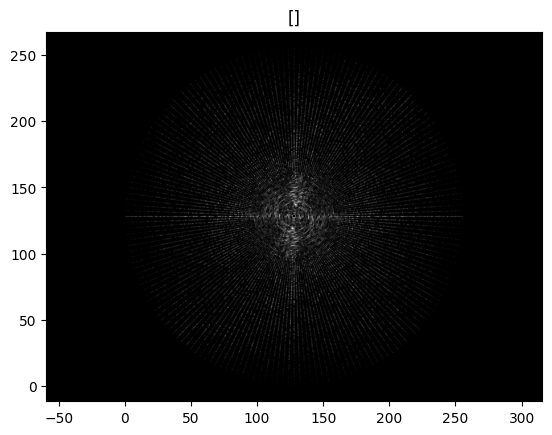

Shape of compensated sampled k-space: (180, 128)
Shape of coordinates: (180, 128, 2)


In [6]:
img_ksp = sigpy.fft(img_original)
sampled_ksp = sigpy.interpolate(img_ksp,coord)
sampled_ksp_compensated = sampled_ksp*dcf
gridded_ksp = sigpy.gridding(sampled_ksp_compensated, coord, (256,256))
sigpy.plot.ScatterPlot(coord, sampled_ksp_compensated)
img_ksp.shape
print(f"Shape of compensated sampled k-space: {sampled_ksp_compensated.shape}")
print(f"Shape of coordinates: {coord.shape}")

In [7]:
# Convert gridded_ksp to the form (n_coils,...) required by EspiritCalib
gridded_ksp = gridded_ksp[np.newaxis,...]
gridded_ksp.shape

(1, 256, 256)

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

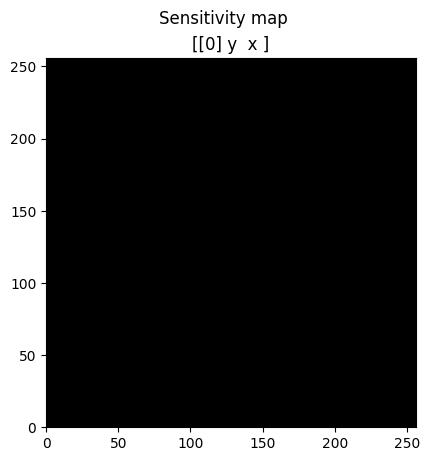

(1, 256, 256)

In [8]:
#Estimate coil sensitivity
mps = sigpy.mri.app.EspiritCalib(gridded_ksp).run()
sigpy.plot.ImagePlot(mps, title='Sensitivity map',mode='l')
mps.shape

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

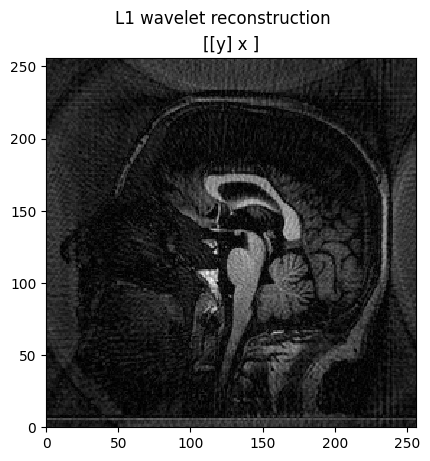

In [9]:
lamda = 0.001
img_reconstructed_1 = sigpy.mri.app.L1WaveletRecon(gridded_ksp, mps, lamda).run()
sigpy.plot.ImagePlot(np.flip(img_reconstructed_1,axis=(0,)), title='L1 wavelet reconstruction')

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

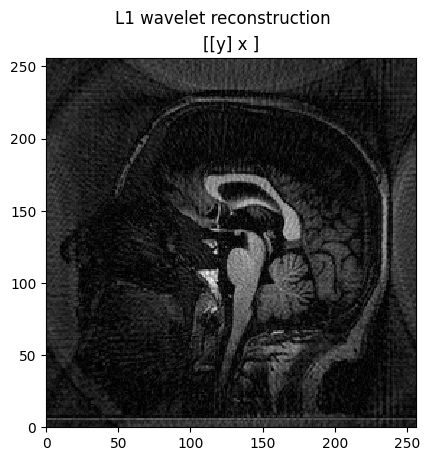

In [19]:
lamda = 0.005
img_reconstructed_2 = sigpy.mri.app.L1WaveletRecon(gridded_ksp, mps, lamda).run()
sigpy.plot.ImagePlot(np.flip(img_reconstructed_2,axis=(0,)), title='L1 wavelet reconstruction')

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

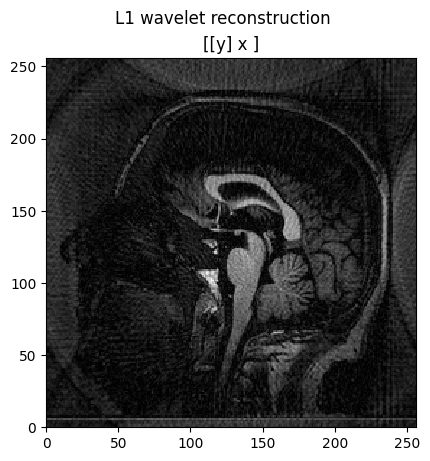

In [10]:
lamda = 0.0001
img_reconstructed_3 = sigpy.mri.app.L1WaveletRecon(gridded_ksp, mps, lamda).run()
sigpy.plot.ImagePlot(np.flip(img_reconstructed_3,axis=(0,)), title='L1 wavelet reconstruction')

## Evaluate the quality of the reconstruction

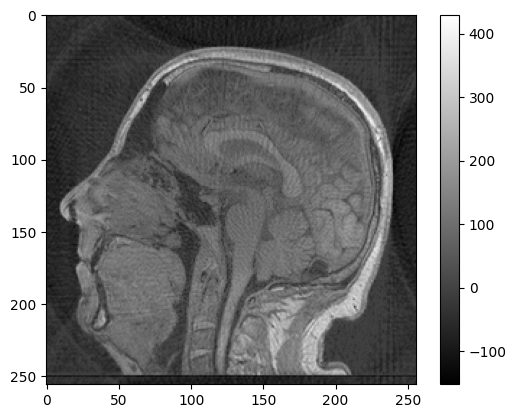

Peak signal-to-noise reatio: 50.65409555702085


In [11]:
from skimage.metrics import peak_signal_noise_ratio as psnr

img_reco_abs = np.abs(img_reconstructed_3)
scale = np.sqrt(np.sum(img_original**2)/np.sum(img_reco_abs**2))
img_reco_scaled = (img_reco_abs * scale).astype(np.int16)

difference = img_original - img_reco_scaled
plt.imshow(difference, cmap='gray')
plt.colorbar()
plt.show()
print(f"Peak signal-to-noise reatio: {psnr(img_original, img_reco_scaled)}")

Mean structural similarity index = 0.20737086394584417


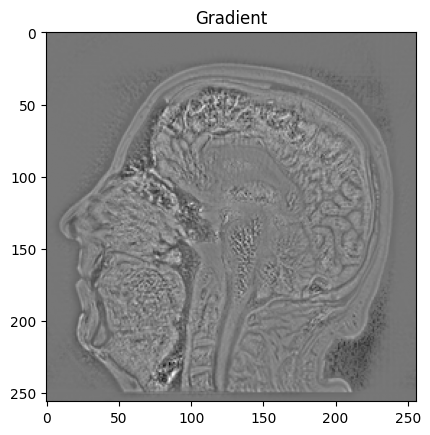

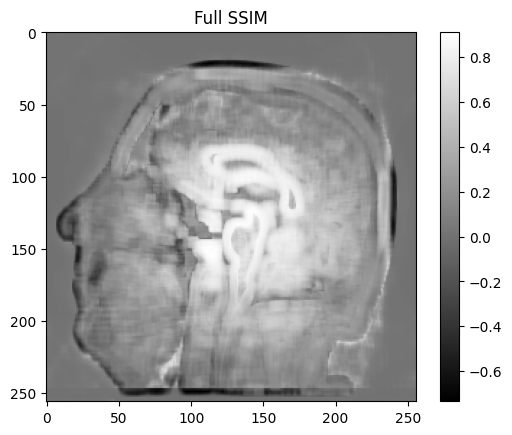

In [12]:
from skimage.metrics import structural_similarity

ssim, grad, S = structural_similarity(img_original, img_reco_scaled, gradient=True, full=True, data_range=(img_original.max() - img_original.min()))
print(f"Mean structural similarity index = {ssim}")
plt.figure()
plt.imshow(grad, cmap='gray')
plt.title("Gradient")
plt.show()

plt.figure()
plt.imshow(S, cmap='gray')
plt.title("Full SSIM")
plt.colorbar()
plt.show()

Now create a function to automate the process of reconstruction

In [26]:
def reconstruct_L1WaveletRecon(ksp_sampled, coord , shape=(256,256)):
    dcf = ((coord[...,0])**2+(coord[...,1])**2)**0.5
    sampled_ksp_compensated = ksp_sampled*dcf
    gridded_ksp = sigpy.gridding(sampled_ksp, coord, (256,256))
    gridded_ksp = gridded_ksp[np.newaxis,...]
    mps = sigpy.mri.app.EspiritCalib(gridded_ksp).run()
    reco = sigpy.mri.app.L1WaveletRecon(ksp_sampled, mps, lamda,wave_name='db4', oshape=shape).run()
    return reco 

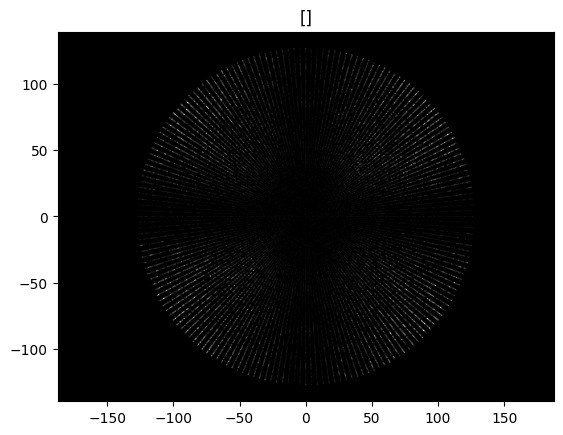

In [16]:
# Test the function
coord = sigpy.mri.radial([180,128,2],[256,256],golden=False)
ksp_sampled = sigpy.interpolate(img_ksp,coord)
sigpy.plot.ScatterPlot(coord, ksp_sampled)

In [19]:
#Now define the reconstruction function and an auxilliar function to scale the image
def scale_reconstruction(reco, original):
    reco = np.abs(reco)
    scale = np.sqrt(np.sum(original**2)/np.sum(reco**2))
    reco = (reco * scale).astype(np.int16)
    return reco

In [2]:
# Testing reconstruction with L1 Wavelet Reconstruction
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import sigpy.mri
import sigpy.plot
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


def translate_spokes_to_img_coord(spokes, im_size=(256,256)):
    x_shift = np.floor(im_size[1]/2) # x_shift determines how columns will be shifted
    y_shift = np.floor(im_size[0]/2) # y_shift determines how rows will be shifted
    new_spokes = []
    for spoke in spokes:
        new_spoke = []
        for point in spoke:
            new_point = [point[0] + x_shift, abs(point[1] - y_shift)]
            new_spoke.append(new_point)
        new_spokes.append(new_spoke)
    return np.array(new_spokes)

#def radial_sampling(ksp, n_spokes, n_samples=256):
#    coord = sigpy.mri.radial([n_spokes,n_samples,2],ksp.shape,golden=False)
#    dcf = ((coord[...,0])**2+(coord[...,1])**2)**0.5
#    coord = translate_spokes_to_img_coord(coord, ksp.shape)
#    sampled = sigpy.interpolate(ksp,coord)
#    return (sampled*dcf), coord # Density-compensated sampled k-space and coordinates


def scale_by_energy(reco, original):
    reco = np.abs(reco)
    scale = np.sqrt(np.sum(original**2)/np.sum(reco**2))
    reco = (reco * scale).astype(np.int16)
    return reco

def scale_by_max(reco, original):
    reco = np.abs(reco)
    reco = (reco/reco.max() * original.max()).astype(np.int16)
    return reco


def reconstruct_L1WaveletRecon(ksp_sampled, coord, lamda, shape=(256,256)):
    dcf = ((coord[...,0])**2+(coord[...,1])**2)**0.5
    sampled_ksp_compensated = ksp_sampled*dcf
    gridded_ksp = sigpy.gridding(sampled_ksp_compensated, coord, (256,256))
    gridded_ksp = gridded_ksp[np.newaxis,...]
    mps = sigpy.mri.app.EspiritCalib(gridded_ksp).run()
    reco = sigpy.mri.app.L1WaveletRecon(ksp_sampled, mps, lamda,wave_name='db4', oshape=shape).run()
    return reco 

if __name__ == "__main__":

    sitk_t1=sitk.ReadImage('files/t1.nii.gz')
    t1=sitk.GetArrayFromImage(sitk_t1)
    original = t1[45]
    ksp = sigpy.fft(original)
    
    acc_factors = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    N_spokes = (256/acc_factors).astype(int)
    lamda = 0.0001
    
    SNRs = []
    SSIMs = []
    recos_nufft = []
    
    for Nsp, acc in zip(N_spokes, acc_factors):
        coord = sigpy.mri.radial([Nsp,128,2],[256,256],golden=False)
        coord = translate_spokes_to_img_coord(coord, ksp.shape)
        ksp_sampled = sigpy.interpolate(ksp,coord,)
        reco = reconstruct_L1WaveletRecon(ksp_sampled, coord, lamda) 
        # print(reco.shape)
        reco = scale_by_max(reco, original)
        # print(reco.shape)
        # Metrics
        difference = (original - reco)/(original.max()-original.min())
        psnr = peak_signal_noise_ratio(original, reco)
        ssim, S = structural_similarity(original, reco, full=True, data_range=(original.max() - original.min()))
        # Plot
        fig, axs = plt.subplots(1, 4)
        fig.set_figwidth(18)
        plt.axis('off')
        figs = []
        figs.append(axs[0].imshow(original, cmap='gray',))
        figs.append(axs[1].imshow(reco, cmap='gray'))
        figs.append(axs[2].imshow(difference, cmap='gray'))
        figs.append(axs[3].imshow(S, cmap='gray'))
        for f, a in zip(figs,axs):
            fig.colorbar(f, ax=a, shrink=0.5)
        axs[0].set_title('Original')
        axs[1].set_title(f'Reconstruction, accf={acc}')
        axs[2].set_title('Difference')
        axs[3].set_title('Full SSIM')
        plt.show()
        print(f"Acceleration factor: {acc},    Number of spokes: {Nsp}, lamda: {lamda} ")
        print(f"PSNR = {psnr},    MSSIM = {ssim}")
        print("============================================================")
        SNRs.append(psnr)
        SSIMs.append(ssim)
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Acceleration factor')
    ax1.set_ylabel('PSNR', color='blue')
    ax1.plot(acc_factors, SNRs, color='blue', label='PSNR')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('MSSIM', color='red')
    ax2.plot(acc_factors, SSIMs, color='red', label='MSSIM')
    ax2.tick_params(axis='y', labelcolor='red')
    # ax2.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
    plt.show()

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Invalid shapes: [1, 256, 256], (128,).